---
title: "Writing Stable Diffusion from Scratch 3"
reading-time: 
date: "2023-3-19"
categories: [fastaipart2,Stable-Diffusion]
---

Things you should know and practice after this lecture : <br>
1- Einsum <br>
2- 2 ways you can do einsum / matmul in pytorch <br>
3- Using GPU / Cuda <br>
4- args and kwargs <br>


All credits go to fastai and all mistakes most likely is mine. This notebook connected to pass two notebooks. So the code is here but I remove most of explanation. You can check past two posts. Enjoy learning ...

## Matrix multiplication from foundations

In [2]:
from pathlib import Path
import pickle, gzip, math, os, time, shutil, matplotlib as mpl, matplotlib.pyplot as plt

## Get data

In [3]:
MNIST_URL='https://github.com/mnielsen/neural-networks-and-deep-learning/blob/master/data/mnist.pkl.gz?raw=true'
path_data = Path('data')
path_data.mkdir(exist_ok=True)
path_gz = path_data/'mnist.pkl.gz'

[urlretrieve](https://docs.python.org/3/library/urllib.request.html#urllib.request.urlretrieve) - (read the docs!)

In [4]:
from urllib.request import urlretrieve
if not path_gz.exists(): urlretrieve(MNIST_URL, path_gz)

In [5]:
!ls -l data

total 16656
-rw-r--r-- 1 root root 17051982 Mar 18 22:05 mnist.pkl.gz


In [6]:
with gzip.open(path_gz, 'rb') as f: ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')

In [7]:
lst1 = list(x_train[0])
vals = lst1[200:210]
vals

[0.0,
 0.0,
 0.0,
 0.19140625,
 0.9296875,
 0.98828125,
 0.98828125,
 0.98828125,
 0.98828125,
 0.98828125]

In [8]:
len(lst1)

784

In [9]:
def chunks(x, sz):
    for i in range(0, len(x), sz): yield x[i:i+sz]

In [10]:
list(chunks(vals, 5))

[[0.0, 0.0, 0.0, 0.19140625, 0.9296875],
 [0.98828125, 0.98828125, 0.98828125, 0.98828125, 0.98828125]]

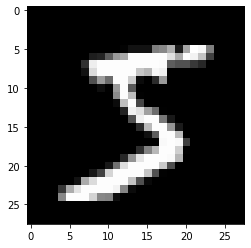

In [11]:
mpl.rcParams['image.cmap'] = 'gray'
plt.imshow(list(chunks(lst1, 28)));

[islice](https://docs.python.org/3/library/itertools.html#itertools.islice)

In [12]:
from itertools import islice

In [13]:
it = iter(vals)
islice(it, 5)

In [14]:
list(islice(it, 5))

[0.0, 0.0, 0.0, 0.19140625, 0.9296875]

In [15]:
list(islice(it, 5))

[0.98828125, 0.98828125, 0.98828125, 0.98828125, 0.98828125]

In [16]:
list(islice(it, 5))

[]

In [17]:
it = iter(lst1)
img = list(iter(lambda: list(islice(it, 28)), []))

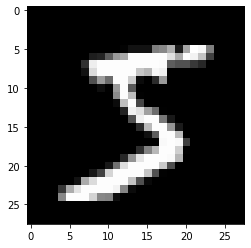

In [18]:
plt.imshow(img);

Use this link to learn more about [iter](https://docs.python.org/3.10/library/functions.html?highlight=iter#iter)

## Matrix and tensor

In [19]:
img[20][15]

0.98828125

In [20]:
class Matrix:
    def __init__(self, xs): self.xs = xs
    def __getitem__(self, idxs): return self.xs[idxs[0]][idxs[1]]

In [21]:
m = Matrix(img)
m[20,15]

0.98828125

Now we can use pytorch.

In [22]:
import torch
from torch import tensor

In [23]:
tensor([1,2,3])

tensor([1, 2, 3])

In [24]:
x_train,y_train,x_valid,y_valid = map(tensor, (x_train,y_train,x_valid,y_valid))
x_train.shape

torch.Size([50000, 784])

In [25]:
x_train.type()

'torch.FloatTensor'

[Tensor documentation](https://pytorch.org/docs/stable/tensors.html)

In [26]:
imgs = x_train.reshape((-1,28,28))
imgs.shape

torch.Size([50000, 28, 28])

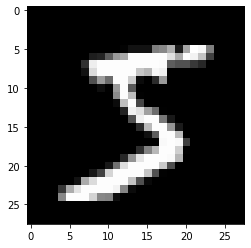

In [27]:
plt.imshow(imgs[0]);

vector rank one tensor 
matrix is a rank 2 tensor
scalor in APL(depend of programming languages) is rank zero tensor

In [28]:
imgs[0,20,15]

tensor(0.9883)

Use destructring again. n number of images. c is full number of colums (784)

In [29]:
n,c = x_train.shape
y_train, y_train.shape

(tensor([5, 0, 4,  ..., 8, 4, 8]), torch.Size([50000]))

in y_train we can find min and max of it. 

In [30]:
min(y_train),max(y_train)

(tensor(0), tensor(9))

In [31]:
y_train.min(), y_train.max()

(tensor(0), tensor(9))

## Random numbers

Based on the Wichmann Hill algorithm used before Python 2.3.

In [32]:
rnd_state = None
def seed(a):
    global rnd_state
    a, x = divmod(a, 30268)
    a, y = divmod(a, 30306)
    a, z = divmod(a, 30322)
    rnd_state = int(x)+1, int(y)+1, int(z)+1

In [33]:
seed(457428938475)
rnd_state

(4976, 20238, 499)

In [34]:
def rand():
    global rnd_state
    x, y, z = rnd_state
    x = (171 * x) % 30269
    y = (172 * y) % 30307
    z = (170 * z) % 30323
    rnd_state = x,y,z
    return (x/30269 + y/30307 + z/30323) % 1.0

In [35]:
rand(),rand(),rand()

(0.7645251082582081, 0.7920889799553945, 0.06912886811267205)

In [36]:
if os.fork(): print(f'In parent: {rand()}')
else:
    print(f'In child: {rand()}')
    os._exit(os.EX_OK)

In parent: 0.9559050644103264
In child: 0.9559050644103264


In [37]:
if os.fork(): print(f'In parent: {torch.rand(1)}')
else:
    print(f'In child: {torch.rand(1)}')
    os._exit(os.EX_OK)

In parent: tensor([0.6953])
In child: tensor([0.6953])


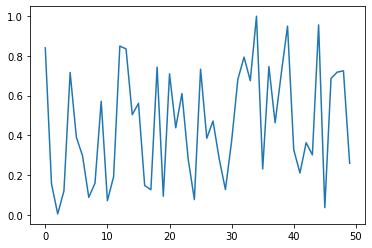

In [38]:
plt.plot([rand() for _ in range(50)]);

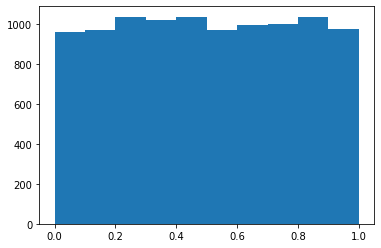

In [39]:
plt.hist([rand() for _ in range(10000)]);

%timeit check the time of excution. 

In [40]:
%timeit -n 10 list(chunks([rand() for _ in range(7840)], 10))

4.6 ms ± 580 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


pytorch version is faster. 

In [41]:
%timeit -n 10 torch.randn(784,10)

103 µs ± 42.8 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Matrix multiplication

In [42]:
torch.manual_seed(1)
weights = torch.randn(784,10)
bias = torch.zeros(10)

In [43]:
m1 = x_valid[:5]
m2 = weights

In [44]:
m1.shape,m2.shape

(torch.Size([5, 784]), torch.Size([784, 10]))

In [45]:
ar,ac = m1.shape # n_rows * n_cols
br,bc = m2.shape
(ar,ac),(br,bc)

((5, 784), (784, 10))

In [46]:
t1 = torch.zeros(ar, bc)
t1.shape

torch.Size([5, 10])

In [47]:
for i in range(ar):         # 5
    for j in range(bc):     # 10
        for k in range(ac): # 784
            t1[i,j] += m1[i,k] * m2[k,j]

In [48]:
t1

tensor([[-10.9417,  -0.6844,  -7.0038,  -4.0066,  -2.0857,  -3.3588,   3.9127,
          -3.4375, -11.4696,  -2.1153],
        [ 14.5430,   5.9977,   2.8914,  -4.0777,   6.5914, -14.7383,  -9.2787,
           2.1577, -15.2772,  -2.6758],
        [  2.2204,  -3.2171,  -4.7988,  -6.0453,  14.1661,  -8.9824,  -4.7922,
          -5.4446, -20.6758,  13.5657],
        [ -6.7097,   8.8998,  -7.4611,  -7.8966,   2.6994,  -4.7260, -11.0278,
         -12.9776,  -6.4443,   3.6376],
        [ -2.4444,  -6.4034,  -2.3984,  -9.0371,  11.1772,  -5.7724,  -8.9214,
          -3.7862,  -8.9827,   5.2797]])

In [49]:
t1.shape

torch.Size([5, 10])

In [50]:
torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
t1

tensor([[-10.94,  -0.68,  -7.00,  -4.01,  -2.09,  -3.36,   3.91,  -3.44, -11.47,  -2.12],
        [ 14.54,   6.00,   2.89,  -4.08,   6.59, -14.74,  -9.28,   2.16, -15.28,  -2.68],
        [  2.22,  -3.22,  -4.80,  -6.05,  14.17,  -8.98,  -4.79,  -5.44, -20.68,  13.57],
        [ -6.71,   8.90,  -7.46,  -7.90,   2.70,  -4.73, -11.03, -12.98,  -6.44,   3.64],
        [ -2.44,  -6.40,  -2.40,  -9.04,  11.18,  -5.77,  -8.92,  -3.79,  -8.98,   5.28]])

In [51]:
import numpy as np
np.set_printoptions(precision=2, linewidth=140)

In [52]:
def matmul(a,b):
    (ar,ac),(br,bc) = a.shape,b.shape
    c = torch.zeros(ar, bc)
    for i in range(ar):
        for j in range(bc):
            for k in range(ac): c[i,j] += a[i,k] * b[k,j]
    return c

How long does it take to run ? Man it too much. It is o(n^3) and it is so slow

In [53]:
%time _=matmul(m1, m2)

CPU times: user 621 ms, sys: 1.34 ms, total: 623 ms
Wall time: 629 ms


In [54]:
ar*bc*ac

39200

## Numba

In [55]:
from numba import njit

In [56]:
@njit
def dot(a,b):
    res = 0.
    for i in range(len(a)): res+=a[i]*b[i]
    return res

In [57]:
from numpy import array

In [58]:
%time dot(array([1.,2,3]),array([2.,3,4]))

CPU times: user 363 ms, sys: 113 ms, total: 476 ms
Wall time: 445 ms


20.0

In [59]:
%time dot(array([1.,2,3]),array([2.,3,4]))

CPU times: user 19 µs, sys: 4 µs, total: 23 µs
Wall time: 26 µs


20.0

Now only two of our loops are running in Python, not three:

In [60]:
def matmul(a,b):
    (ar,ac),(br,bc) = a.shape,b.shape
    c = torch.zeros(ar, bc)
    for i in range(ar):
        for j in range(bc): c[i,j] = dot(a[i,:], b[:,j])
    return c

In [61]:
m1a,m2a = m1.numpy(),m2.numpy()

This is the test. 

In [62]:
from fastcore.test import *

In [63]:
test_close(t1,matmul(m1a, m2a))

2000 time faster. We change inner most loop. 

In [64]:
%timeit -n 50 matmul(m1a,m2a)

383 µs ± 30.8 µs per loop (mean ± std. dev. of 7 runs, 50 loops each)


## Elementwise ops

[TryAPL](https://tryapl.org/)

In [65]:
a = tensor([10., 6, -4])
b = tensor([2., 8, 7])
a,b

(tensor([10.,  6., -4.]), tensor([2., 8., 7.]))

Elementwise addition

In [66]:
a + b

tensor([12., 14.,  3.])

Check lecture for awesome implementation of mean. 

In [67]:
(a < b).float().mean()

tensor(0.67)

Rank two tensor , aka Matrix. 

In [68]:
m = tensor([[1., 2, 3], [4,5,6], [7,8,9]]); m

tensor([[1., 2., 3.],
        [4., 5., 6.],
        [7., 8., 9.]])

# Frobenius norm:

$$\| A \|_F = \left( \sum_{i,j=1}^n | a_{ij} |^2 \right)^{1/2}$$

*Hint*: you don't normally need to write equations in LaTeX yourself, instead, you can click 'edit' in Wikipedia and copy the LaTeX from there (which is what I did for the above equation). Or on arxiv.org, click "Download: Other formats" in the top right, then "Download source"; rename the downloaded file to end in `.tgz` if it doesn't already, and you should find the source there, including the equations to copy and paste. This is the source LaTeX that I pasted to render the equation above:

```latex
$$\| A \|_F = \left( \sum_{i,j=1}^n | a_{ij} |^2 \right)^{1/2}$$
```

In [69]:
sf = (m*m).sum()
sf

tensor(285.)

In [70]:
sf.sqrt()

tensor(16.88)

In [71]:
m[2,:],m[:,2]

(tensor([7., 8., 9.]), tensor([3., 6., 9.]))

In [72]:
m[2]

tensor([7., 8., 9.])

We can use elementwise operation and get ride of inner loop. 

In [73]:
def matmul(a,b):
    (ar,ac),(br,bc) = a.shape,b.shape
    c = torch.zeros(ar, bc)
    for i in range(ar):
        for j in range(bc): c[i,j] = (a[i,:] * b[:,j]).sum()
    return c

Test to see they are the same. 

In [74]:
test_close(t1,matmul(m1, m2))

In [75]:
%timeit -n 50 _=matmul(m1, m2)

1.2 ms ± 168 µs per loop (mean ± std. dev. of 7 runs, 50 loops each)


Now that we wrote it , we can use equivalent of pytorch. (torch.dot)

In [76]:
def matmul(a,b):
    (ar,ac),(br,bc) = a.shape,b.shape
    c = torch.zeros(ar, bc)
    for i in range(ar):
        for j in range(bc): c[i,j] = torch.dot(a[i,:], b[:,j])
    return c

In [77]:
test_close(t1,matmul(m1, m2))

In [78]:
%timeit -n 50 _=matmul(m1, m2)

831 µs ± 104 µs per loop (mean ± std. dev. of 7 runs, 50 loops each)


## Broadcasting

The term **broadcasting** describes how arrays with different shapes are treated during arithmetic operations.

From the [Numpy Documentation](https://docs.scipy.org/doc/numpy-1.10.0/user/basics.broadcasting.html):

    The term broadcasting describes how numpy treats arrays with 
    different shapes during arithmetic operations. Subject to certain 
    constraints, the smaller array is “broadcast” across the larger 
    array so that they have compatible shapes. Broadcasting provides a 
    means of vectorizing array operations so that looping occurs in C
    instead of Python. It does this without making needless copies of 
    data and usually leads to efficient algorithm implementations.
    
In addition to the efficiency of broadcasting, it allows developers to write less code, which typically leads to fewer errors.

*This section was adapted from [Chapter 4](http://nbviewer.jupyter.org/github/fastai/numerical-linear-algebra/blob/master/nbs/4.%20Compressed%20Sensing%20of%20CT%20Scans%20with%20Robust%20Regression.ipynb#4.-Compressed-Sensing-of-CT-Scans-with-Robust-Regression) of the fast.ai [Computational Linear Algebra](https://github.com/fastai/numerical-linear-algebra) course.*

### Broadcasting with a scalar

In [79]:
a

tensor([10.,  6., -4.])

Simplest way of broadcasting. 

In [80]:
a > 0

tensor([ True,  True, False])

In [81]:
a + 1

tensor([11.,  7., -3.])

In [82]:
m

tensor([[1., 2., 3.],
        [4., 5., 6.],
        [7., 8., 9.]])

multiply

In [83]:
2*m

tensor([[ 2.,  4.,  6.],
        [ 8., 10., 12.],
        [14., 16., 18.]])

### Broadcasting a vector to a matrix

In [84]:
c = tensor([10.,20,30]); c

tensor([10., 20., 30.])

In [85]:
m

tensor([[1., 2., 3.],
        [4., 5., 6.],
        [7., 8., 9.]])

In [86]:
m.shape,c.shape

(torch.Size([3, 3]), torch.Size([3]))

In [87]:
m + c

tensor([[11., 22., 33.],
        [14., 25., 36.],
        [17., 28., 39.]])

In [88]:
c + m

tensor([[11., 22., 33.],
        [14., 25., 36.],
        [17., 28., 39.]])

In [89]:
t = c.expand_as(m)

In [90]:
t

tensor([[10., 20., 30.],
        [10., 20., 30.],
        [10., 20., 30.]])

In [91]:
m + t

tensor([[11., 22., 33.],
        [14., 25., 36.],
        [17., 28., 39.]])

In [92]:
t.storage()

 10.0
 20.0
 30.0
[torch.storage.TypedStorage(dtype=torch.float32, device=cpu) of size 3]

In [93]:
t.stride(), t.shape

((0, 1), torch.Size([3, 3]))

In [94]:
c.unsqueeze(0), c[None, :]

(tensor([[10., 20., 30.]]), tensor([[10., 20., 30.]]))

In [95]:
c.shape, c.unsqueeze(0).shape

(torch.Size([3]), torch.Size([1, 3]))

In [96]:
c.unsqueeze(1), c[:, None]

(tensor([[10.],
         [20.],
         [30.]]), tensor([[10.],
         [20.],
         [30.]]))

In [97]:
c.shape, c.unsqueeze(1).shape

(torch.Size([3]), torch.Size([3, 1]))

we can avoid : and say c[None].

In [98]:
c[None].shape,c[...,None].shape

(torch.Size([1, 3]), torch.Size([3, 1]))

In [99]:
c[:,None].expand_as(m)

tensor([[10., 10., 10.],
        [20., 20., 20.],
        [30., 30., 30.]])

In [100]:
m + c[:,None]

tensor([[11., 12., 13.],
        [24., 25., 26.],
        [37., 38., 39.]])

This adding the vector to each row. 

In [101]:
m + c[None,:]

tensor([[11., 22., 33.],
        [14., 25., 36.],
        [17., 28., 39.]])

### Broadcasting Rules

In [102]:
c[None,:]

tensor([[10., 20., 30.]])

In [103]:
c[None,:].shape

torch.Size([1, 3])

In [104]:
c[:,None]

tensor([[10.],
        [20.],
        [30.]])

In [105]:
c[:,None].shape

torch.Size([3, 1])

In [106]:
c[None,:] * c[:,None]

tensor([[100., 200., 300.],
        [200., 400., 600.],
        [300., 600., 900.]])

In [107]:
c[None] > c[:,None]

tensor([[False,  True,  True],
        [False, False,  True],
        [False, False, False]])

In [108]:
m*m

tensor([[ 1.,  4.,  9.],
        [16., 25., 36.],
        [49., 64., 81.]])

When operating on two arrays/tensors, Numpy/PyTorch compares their shapes element-wise. It starts with the **trailing dimensions**, and works its way forward. Two dimensions are **compatible** when
It goes from right to left.
- they are equal, or
- one of them is 1, in which case that dimension is broadcasted to make it the same size

Arrays do not need to have the same number of dimensions. For example, if you have a `256*256*3` array of RGB values, and you want to scale each color in the image by a different value, you can multiply the image by a one-dimensional array with 3 values. Lining up the sizes of the trailing axes of these arrays according to the broadcast rules, shows that they are compatible:

    Image  (3d array): 256 x 256 x 3
    Scale  (1d array):             3
    Result (3d array): 256 x 256 x 3

The [numpy documentation](https://docs.scipy.org/doc/numpy-1.13.0/user/basics.broadcasting.html#general-broadcasting-rules) includes several examples of what dimensions can and can not be broadcast together.

## Matmul with broadcasting

In [109]:
digit = m1[0]
digit.shape,m2.shape

(torch.Size([784]), torch.Size([784, 10]))

In [110]:
digit[:,None].shape

torch.Size([784, 1])

In [111]:
digit[:,None].expand_as(m2).shape

torch.Size([784, 10])

In [112]:
(digit[:,None]*m2).shape

torch.Size([784, 10])

In [113]:
def matmul(a,b):
    (ar,ac),(br,bc) = a.shape,b.shape
    c = torch.zeros(ar, bc)
    for i in range(ar):
#       c[i,j] = (a[i,:] * b[:,j]).sum()      # previous version
        c[i]   = (a[i,:,None] * b).sum(dim=0) # broadcast version
    return c

In [114]:
test_close(t1,matmul(m1, m2))

In [115]:
%timeit -n 50 _=matmul(m1, m2)

231 µs ± 71.6 µs per loop (mean ± std. dev. of 7 runs, 50 loops each)


In [116]:
tr = matmul(x_train, weights)
tr

tensor([[  0.96,  -2.96,  -2.11,  ..., -15.09, -17.69,   0.60],
        [  6.89,  -0.34,   0.79,  ..., -17.13, -25.36,  16.23],
        [-10.18,   7.38,   4.13,  ...,  -6.73,  -6.79,  -1.58],
        ...,
        [  7.40,   7.64,  -3.50,  ...,  -1.02, -16.22,   2.07],
        [  3.25,   9.52,  -9.37,  ...,   2.98, -19.58,  -1.96],
        [ 15.70,   4.12,  -5.62,  ...,   8.08, -12.21,   0.42]])

In [117]:
tr.shape

torch.Size([50000, 10])

In [118]:
%time _=matmul(x_train, weights)

CPU times: user 1.26 s, sys: 2.76 ms, total: 1.26 s
Wall time: 1.28 s


## Einstein summation

So we're 5000 times faster than we started out. So another trick that we can use, which I'm a big fan of, is something called Einstein summation. And Einstein summation is a compact representation for representing products and sums. And this is an example of an Einstein summation. And what we're going to do now is begin to replicate our matrix product with an Einstein summation. And believe it or not, the entire thing can be pushed down to just these characters,(ik,kj->ikj) which is pretty amazing. So let me explain what's happening here. The arrow is separating the left hand side from the right hand side. The left hand side is the inputs. The right hand side is the output. The comma is between each inputs. So there are two inputs. The letters are just names that you're giving to the number of rise in the number of columns. So the first matrix we're multiplying by has i rows and k columns, the second has k rows and j columns. It's going to go through a process which creates a new matrix that actually this is not even doing this is not yet doing the matrix multiplication. This is without the sum. This one's going to create a new matrix that contains i rows, Well, how do we set i faces and k rows and j columns are rank three tensor. So the number of letters is going to be the rank and the rules of how this works is that if you repeat letters between input arrays,(ik,kj) so here's my inputs (ik,kj) and we've got a repeated letter. 
It means that values along those axes will be multiplied together. So it means that each item across a row will be multiplied by each item down each column to create this i by k by j output tensor. So to remind you, our first matrix is five by 734 that's m1. Our second matrix is 784 by ten that's m2. So i is 5, k is 784 and J is 10. So if I do this torch.einsum then I will end up with a i k by k, it'll be five by 784 by ten. And if you have a look, I've run it here on these two tensor and m1 and m2 and the shape of the result is five by 784 by ten. And what it contains is the original five rows of m1 the original ten columns of m2, and then for the other 784 that I mentioned, they all multiplied together because it's been copied. It's been copied between the two arguments to the einsum. And so if we now sum up that over this dimension, we get back, if we have a look, it was that we printed this somewhere. Oh, there it is. So what we get back, if we go back to the original matrix multiply, we do. We had 10.94 negative, negative point six, eight, etc. And so now with this Einstein summation version, we've got back exactly the same thing because what it's done is it's taken each of these columns by rows, multiplied them together to get this five by seven, eight, four by ten, and then add it up that 784 for each one, which is exactly what matrix multiplication does. But we're going to use one of the two things from Einstein. The second one says if we omit a letter from the output. So the bit on the right of the arrow, it means those values will be summed. So if we remove this K, which gives us i , k and k,j goes to i,j, so we've removed the k entirely. That means that sum happens automatically. So if we run this, as you say, we get back again. Matrix multiplication. So Einstein summation notation is, you know, it takes some practice getting used to you, but it's very convenient and once you get used to it, it's actually a really nice way of thinking about what's going on. 
And as we'll see in lots of examples, often you can really simplify your code by using just a tiny little Einstein summation, and it doesn't even have to be a sum, right? You can you don't have to omit any letters if you're just doing products. So maybe it's a bit misnamed. So we can now define a matmul as simply this torch.einsum. So if we now check it, the test_close that the original result is equal to this new matmul. And yes, it is. And let's see how the speed looks. Okay. And that was for the whole thing. So compared to 600 milliseconds. So as you can see, this is much faster than even the very fast broadcasting approach we used. So this is a pretty good trick is torch.einsum. Some okay, but of course we don't have to do any of those things because PyTorch already knows how to do matmul. So there's two ways we can run matmul directly. In PyTorch, you can use a special @ operator. So x_train@weights is the same as matmul train comma weights as you say, test_close or you can say torch.matmul. And interestingly, as you can see here, the speed is about the same as the  einsum. So there's no particular harm that people reason not to do an einsum. So when I say einsum, that stands for Einstein summation notation. All right, let's go faster. Still. Currently we're just using my CPU, but I have a GPU. It would be nice to use it. So how does a GPU work at in video? GPU and indeed pretty much all GPU use. The way they work is that they do lots and lots of things in parallel and you have to actually tell the GPU what are all the things you want to do in parallel or one a time. And so what we're going to do is we're going to write in Pure Python something that works like a GPU. You expect it won't actually be in parallel, so it won't be fast at all. But the first thing we have to do if we're going to get something working in parallel is we have to create a function that can calculate just one thing even if a thousand other things are happening at the same time, it won't interact with anything else. And there's actually a very easy way to think about matrix multiplication in this way, which is what if we try to create something which, just as we've done here, fills in a single, the single item of the result? 

[Einstein summation](https://ajcr.net/Basic-guide-to-einsum/) ([`einsum`](https://numpy.org/doc/stable/reference/generated/numpy.einsum.html)) is a compact representation for combining products and sums in a general way. The key rules are:

- Repeating letters between input arrays means that values along those axes will be multiplied together.
- Omitting a letter from the output means that values along that axis will be summed.

In [119]:
m1.shape,m2.shape

(torch.Size([5, 784]), torch.Size([784, 10]))

So far we removed 2 inner loop and we are 5k faster than original for loop. It is more cleaner code and also faster. 

In [120]:
# c[i,j] += a[i,k] * b[k,j]
# c[i,j] = (a[i,:] * b[:,j]).sum()
mr = torch.einsum('ik,kj->ikj', m1, m2)
mr.shape

torch.Size([5, 784, 10])

In [121]:
mr.sum(1)

tensor([[-10.94,  -0.68,  -7.00,  -4.01,  -2.09,  -3.36,   3.91,  -3.44, -11.47,  -2.12],
        [ 14.54,   6.00,   2.89,  -4.08,   6.59, -14.74,  -9.28,   2.16, -15.28,  -2.68],
        [  2.22,  -3.22,  -4.80,  -6.05,  14.17,  -8.98,  -4.79,  -5.44, -20.68,  13.57],
        [ -6.71,   8.90,  -7.46,  -7.90,   2.70,  -4.73, -11.03, -12.98,  -6.44,   3.64],
        [ -2.44,  -6.40,  -2.40,  -9.04,  11.18,  -5.77,  -8.92,  -3.79,  -8.98,   5.28]])

In [122]:
torch.einsum('ik,kj->ij', m1, m2)

tensor([[-10.94,  -0.68,  -7.00,  -4.01,  -2.09,  -3.36,   3.91,  -3.44, -11.47,  -2.12],
        [ 14.54,   6.00,   2.89,  -4.08,   6.59, -14.74,  -9.28,   2.16, -15.28,  -2.68],
        [  2.22,  -3.22,  -4.80,  -6.05,  14.17,  -8.98,  -4.79,  -5.44, -20.68,  13.57],
        [ -6.71,   8.90,  -7.46,  -7.90,   2.70,  -4.73, -11.03, -12.98,  -6.44,   3.64],
        [ -2.44,  -6.40,  -2.40,  -9.04,  11.18,  -5.77,  -8.92,  -3.79,  -8.98,   5.28]])

In [123]:
def matmul(a,b): return torch.einsum('ik,kj->ij', a, b)

In [124]:
test_close(tr, matmul(x_train, weights), eps=1e-3)

In [125]:
%timeit -n 5 _=matmul(x_train, weights)

30.5 ms ± 2.02 ms per loop (mean ± std. dev. of 7 runs, 5 loops each)


## pytorch op

Now that we wrote matmul we can use pytorch matmul version. The speed is almost the same. We can use pytorch's function or operator directly for matrix multiplication.

In [126]:
test_close(tr, x_train@weights, eps=1e-3)

In [127]:
%timeit -n 5 _=torch.matmul(x_train, weights)

32 ms ± 4.72 ms per loop (mean ± std. dev. of 7 runs, 5 loops each)


So how do we create something that just fills in row zero column zero? Well, what we could do is we could create a new matmul where we're going to pass in the coordinates of the place that we want to fill in. So I'm going to start by passing that zero comma zero we'll pass at the matrices We want to multiply and we are passing a tensor that we've pre-filled in with zeros to put the result into. So they're going to say, okay, the result is torch.zeros() rows by columns, cal matmul for location zero comma zero passing in those two matrices and the bunch of zeros matrix ready to put the result in. And if we call that we get the answer in cell zero zero. So here's an implementation of that. So the implementation is first of all, we've been past the zero comma zero coordinates, so let's de structure them. So hopefully you've been experimenting with de structuring that so important. You said all the time into i and j throw in the column, make sure that that is inside the bounds of our output matrix and we're going to start by start at zero and loop through all of the all of the columns of a in the rows of b for i and j, just like the very innermost loop of our very first Python attempt and then at the end pop that into the output. So here's something that fills in one piece with a grid successfully. So we could call this row by columns times each time passing in a different grid. And we could do that in parallel because none of those different locations interact with any other location. So something which can calculate a little piece of, of an output on a GPU is called a kernel. So we call this a kernel. And so now we can create something called launch kernel, we pass at the kernel. So that's the function. So here's an example launch kernel passing in the function and how many rows and how many columns are there in the output grid. And then give me any arguments that you need to calculate it. So in python *args just says any additional arguments that you pass are going to be put into an array called args. If you do something like C, you might have seen like variadic arguments parameters. It's a same basic idea. So we're going to be calling launch kernel. 

## CUDA

How to use GPU instead of CPU. GPU does many more thing at the same time. CPU does not do that. We can compute each cell at the same time because none of those computation interact with other location.

So we're going to be calling launch kernel. We're going to be saying launch the kernel matmul using all the rows of a or the columns of b, and then the args which are going to be in star args are going to be m1, the first matrix, m2 the second matrix n res  another touched zeros we just created. So launch kernel, it's going to loop through the rows of a and then for each row of a loop through the columns of b and call the kernel which is matmul on that grid location and passing in m1, m2 and res. So I star args here is going to unpack that and pass them as three separate arguments. And if I run that, run all of that, you'll see it's done it, it's filled in the exact same matrix. Okay. So that's actually not fast at all. It's not doing anything in parallel, but it's the basic idea. So now to actually do it in parallel, we have to use something called Cuda. So Cuda is a programing model for Nvidia GPUs and to program in CUDA from Python. The easiest way currently to do that is be something called Numba. And Numba is a compiler where you've seen it actually already for non GPU. It's a compiler that takes Python code and spits out, you know, compiled fast machine code. If you use its CUDA module, it'll actually spit out GPU accelerated CUDA code. So rather than using an @njit like before, we now say @cuda.jit  and it behaves a little bit differently but you'll see that this matmul let me copy the other one over so you can compare cup it, compare it to our Python one, our Python matmul and this @cuda.jit matmul Look I think identical except for one thing. Instead of passing in the grid, there's a special magic thing called cuda.gird()  And you say how many dimensions just my grid have? And you unpack it so that's you don't have to. It's just a little convenience. That Numba does for you. You don't have to pass over the grid, it passes it over for you. So it doesn't need this grid. Other than that, these two are identical, but the decorator is going to compile that into your GPU code. So now we need to create our output tensor just like before, and we need to do something else, which is we have to take our input matrices and our output. So our input tenses, the matrices in this case and the output tensor and we have to move them to the GPU, you I should say, copy them to the GPU. 

In [128]:
def matmul(grid, a,b,c):
    i,j = grid
    if i < c.shape[0] and j < c.shape[1]:
        tmp = 0.
        for k in range(a.shape[1]): tmp += a[i, k] * b[k, j]
        c[i,j] = tmp

In [129]:
res = torch.zeros(ar, bc)
matmul((0,0), m1, m2, res)
res

tensor([[-10.94,   0.00,   0.00,   0.00,   0.00,   0.00,   0.00,   0.00,   0.00,   0.00],
        [  0.00,   0.00,   0.00,   0.00,   0.00,   0.00,   0.00,   0.00,   0.00,   0.00],
        [  0.00,   0.00,   0.00,   0.00,   0.00,   0.00,   0.00,   0.00,   0.00,   0.00],
        [  0.00,   0.00,   0.00,   0.00,   0.00,   0.00,   0.00,   0.00,   0.00,   0.00],
        [  0.00,   0.00,   0.00,   0.00,   0.00,   0.00,   0.00,   0.00,   0.00,   0.00]])

*args any additional argument(s) will be put into an array called args. This is the idea. 

In [130]:
def launch_kernel(kernel, grid_x, grid_y, *args, **kwargs):
    for i in range(grid_x):
        for j in range(grid_y): kernel((i,j), *args, **kwargs)

In [131]:
res = torch.zeros(ar, bc)
launch_kernel(matmul, ar, bc, m1, m2, res)
res

tensor([[-10.94,  -0.68,  -7.00,  -4.01,  -2.09,  -3.36,   3.91,  -3.44, -11.47,  -2.12],
        [ 14.54,   6.00,   2.89,  -4.08,   6.59, -14.74,  -9.28,   2.16, -15.28,  -2.68],
        [  2.22,  -3.22,  -4.80,  -6.05,  14.17,  -8.98,  -4.79,  -5.44, -20.68,  13.57],
        [ -6.71,   8.90,  -7.46,  -7.90,   2.70,  -4.73, -11.03, -12.98,  -6.44,   3.64],
        [ -2.44,  -6.40,  -2.40,  -9.04,  11.18,  -5.77,  -8.92,  -3.79,  -8.98,   5.28]])

Now we use cuda so it will do multiply computation at the same time. 

In [132]:
from numba import cuda

In [133]:
def matmul(grid, a,b,c):
    i,j = grid
    if i < c.shape[0] and j < c.shape[1]:
        tmp = 0.
        for k in range(a.shape[1]): tmp += a[i, k] * b[k, j]
        c[i,j] = tmp

So cuda.to_device() copies a tensor to the GPU. And so we've got three things getting copied to the GPU here and therefore we store the three things over here. Another way I could have written this is I could have said map, which I kind of quite like doing a function which is cuda.to_device to each of these arguments and this would be the same thing. This is going to call CUDA dot device on x_train and put it in here on weights and put it in here and an r and put it in rg. That's a slightly more convenient way to do it. Okay, so we've got our 50,000 by ten output. That's just all zeros. Of course, that's just how we created it. And now we're going to try and fill it in. There is a there's a particular detail that you don't have to worry about too much, which is in CUDA They don't just have a grid, but there's also a concept of blocks and there's something we call here TPP, which is threads per block. This is just a detail of the kind of programing model you don't have to worry about too much. You can just basically copy this. And what it's going to do is it's going to call each grid item in parallel and with a number of different processes, basically. So this is just the code which turns the grid into blocks. And so you don't have to worry too much about the details of that. You just always run it. 

Decorator compile it to GPU code. 

In [134]:
@cuda.jit
def matmul(a,b,c):
    i, j = cuda.grid(2)
    if i < c.shape[0] and j < c.shape[1]:
        tmp = 0.
        for k in range(a.shape[1]): tmp += a[i, k] * b[k, j]
        c[i,j] = tmp

In [135]:
!pip install numba

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [136]:
from numba import cuda
r = np.zeros(tr.shape)
m1g,m2g,rg = cuda.to_device(x_train),cuda.to_device(weights),cuda.to_device(r)

In [137]:
r.shape

(50000, 10)

In [138]:
TPB = 16
rr,rc = r.shape
blockspergrid = (math.ceil(rr / TPB), math.ceil(rc / TPB))
blockspergrid

(3125, 1)

Okay. And so now how do you call the equivalent of launch kernal?  it's it's a slightly weird way to do it, but it works fine. You call matmul, but because matmul has cuda.jit, it's got a special thing, which is you have to put something in square brackets afterwards, which is you have to tell it how many blocks per grid. That's just the result from the previous cell and how many threads per block in each of the two dimensions. So again, you can just copy and paste this from my version, but then you pass in the three arguments to the function. This will be a, c, and c, and this. Okay, this is, this is how you launch a kernel. So this will launch the kernel matmul on the GPU. You at the end of it, rg is going to get filled in. It's gone. It's on the GPU, which is not much good to us so we don't have to copy it back to the CPU, which is called the host copy to host to a run that and it's done and test_close shows us that result is similar to our original results. So it seems to be working. So that's great. So I see Sylvor on the YouTube chat is finding that it's not working on his Mac. That's right. So this will only work on it in NVIDIA CPU as basically all of the GPU, nearly all the CPU stuff we look at only works on video.

In [139]:
matmul[blockspergrid, (TPB,TPB)](m1g,m2g,rg)
r = rg.copy_to_host()
test_close(tr, r, eps=1e-3)

Mac GPUs are gradually starting to get a little bit of support from machine learning libraries, but it's taking quite a while. It's been, you know, it's got quite a way to go. As I say this at least towards the end of 2022, if this works for you and later on that's yeah, that's great. Okay, so let's time how fast that is. Okay, so that was 3.6 1 milliseconds. And so if we compare that to the PyTorch matmul on CPU, that was 15 milliseconds. So that's great. So it's faster still. So how much faster? Oh, by the way, we can actually go faster than that, which is we can use the exact same code we had from the PyTorch up. But here's a trick. If you just take your tensor and write .cuda after it, it copies it over to the GPU. If it's on a if it's on a Nvidia GPUs, you do the same for weights.cuda. So these are two cuda versions and now I can do the whole thing. And this will actually run on the GPU and then to copy it back to the host, you just say .cpu(). So if we look to see how fast that is, 458 ms .So yeah, that is somebody you just pointed out that I wrote the wrong thing here 1e-3. Okay, so how much faster is that? Well full 458 microseconds original on the whole data set was 663 microseconds. So compared to our broadcast version, we are another 1000 times faster.
So overall, this version here, compared to our original version, which was here, the difference in performance is 5 million x , So when you say people say, Yeah, Python can be pretty slow, it can be better to run the stuff on the GPU if possible. We're not talking about a 20% change, we're talking about a 5 million x change. So that's a big deal. And so that's why you need to be running stuff on the GPU. All right. Some folks on YT are wondering how on earth I'm running cuda when I'm on a mac and given it sets localhost here, that's because I'm using something called SSH tunneling, which we might get to sometime. I suspect my life coding from the previous course might have covered that already, but this is basically you can use a Jupyter notebook that's running anywhere in the world from your own machine using something called SSH Tunneling, which is a good thing to look up a OK when a person asks if Einstein summation borrows anything from APL.
Oh, yes, it does, actually. So it's kind of the other way around. Actually. APL borrows it from Einstein notation. I don't know if you remember I mentioned that Iverson, when he developed APL was heavily influenced by tensor analysis. And so this Einstein notation is very heavily used there. If you'll notice a key thing that happens in Einstein notation is there's no loop. You know, there isn't this kind of sigma, you know, i from here to here and then you put the i inside the function that you're summing up, everything's implicit and APL takes that a very long way and, and J takes it even further, which is what Iverson developed after APL and this kind of general idea of of removing the index is very important in APL and it's become very important in numpy PyTorch TensorFlow and so forth.
All right. So finally we know how to multiply matrices. Congratulations. So let's practice that. That's practice what we've learned. So we're going to go to zero two main shift to practice this. And so we're going to try to exercise our kind of tensor manipulation operation muscles in this section. And the key actually endpoint for this is the homework. And so what you need to be doing is getting yourself to a point that you could implement something like this, but for a different algorithm, why do we care about this? 

In [140]:
%%timeit -n 10
matmul[blockspergrid, (TPB,TPB)](m1g,m2g,rg)
r = rg.copy_to_host()

10.9 ms ± 3.04 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [141]:
m1c,m2c = x_train.cuda(),weights.cuda()

In [142]:
r=(m1c@m2c).cpu()

In [143]:
%timeit -n 10 r=(m1c@m2c).cpu()

2.27 ms ± 288 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


Our broadcasting version was >500ms, and our CUDA version is around 0.5ms, which is another 1000x improvement compared to broadcasting. So our total speedup is around 5 million times!